In [1]:
# Necessary Dependencies
import numpy as np 
import pandas as pd 
!pip install utils
from utils import *
from glob import glob
import matplotlib.pyplot as plt
import os
from sklearn.model_selection import train_test_split
from itertools import chain
from datetime import datetime
import statistics
from tqdm import tqdm
import tensorflow as tf
# DenseNet Dependencies
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.activations import sigmoid
from tensorflow.keras.layers import Dense,Conv2D, Flatten, Dropout, MaxPooling2D, GlobalAveragePooling2D
from tensorflow.keras.models import Model, Sequential
from tensorflow.keras.metrics import Accuracy, Precision, Recall, AUC, BinaryAccuracy, FalsePositives, FalseNegatives, TruePositives, TrueNegatives
from keras import regularizers
from tensorflow.keras.callbacks import CSVLogger, ModelCheckpoint
from tensorflow.keras.losses import BinaryCrossentropy
from tensorflow.keras.optimizers import SGD, Adam
from tensorflow.keras.applications import DenseNet121, DenseNet169, DenseNet201, VGG16, ResNet50, InceptionResNetV2, InceptionV3
from keras import backend as K
from tensorflow.keras import Sequential
import keras 
import matplotlib
from sklearn.metrics import roc_curve, auc, roc_auc_score
from tensorflow.keras.callbacks import ModelCheckpoint, ReduceLROnPlateau, LearningRateScheduler
from sklearn.metrics import roc_curve, auc
print('Started')

Started


In [2]:
print('---Train Images-----')

path, dirs, files = next(os.walk("../input/intracranial-brain-hemorrhage-ct-images/intracranial brain hemorrhage dataset/Original/Train/Hemorrhage/hemorrhage_images"))
file_count = len(files)
print('Hemorrhage:',file_count)
path, dirs, files = next(os.walk("../input/intracranial-brain-hemorrhage-ct-images/intracranial brain hemorrhage dataset/Original/Train/Normal/normal_images"))
file_count = len(files)
print('Normal:',file_count)

---Train Images-----
Hemorrhage: 825
Normal: 1426


In [3]:
print('---Test Images-----')

path, dirs, files = next(os.walk("../input/intracranial-brain-hemorrhage-ct-images/intracranial brain hemorrhage dataset/Original/Test/Hemorrhage/hemorrhage_images"))
file_count = len(files)
print('Hemorrhage:',file_count)
path, dirs, files = next(os.walk("../input/intracranial-brain-hemorrhage-ct-images/intracranial brain hemorrhage dataset/Original/Test/Normal/normal_images"))
file_count = len(files)
print('Normal:',file_count)

---Test Images-----
Hemorrhage: 125
Normal: 125


In [4]:
image_size = (224, 224)
batch_size = 32

train_df = tf.keras.preprocessing.image_dataset_from_directory(
    "../input/intracranial-brain-hemorrhage-ct-images/intracranial brain hemorrhage dataset/Original/Train",
    validation_split=0.20,
    subset="training",
    seed=1337,
    image_size=image_size,
    batch_size=batch_size,
)
val_df = tf.keras.preprocessing.image_dataset_from_directory(
    "../input/intracranial-brain-hemorrhage-ct-images/intracranial brain hemorrhage dataset/Original/Train",
    validation_split=0.2,
    subset="validation",
    seed=333,
    image_size=image_size,
    batch_size=batch_size,
)
test_df = tf.keras.preprocessing.image_dataset_from_directory(
    "../input/intracranial-brain-hemorrhage-ct-images/intracranial brain hemorrhage dataset/Original/Test",
    image_size=image_size,
    batch_size=batch_size,
)


Found 2251 files belonging to 2 classes.
Using 1801 files for training.
Found 2251 files belonging to 2 classes.
Using 450 files for validation.
Found 250 files belonging to 2 classes.


In [5]:
import os
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
import os
from tensorflow.keras.preprocessing.image import ImageDataGenerator

In [6]:
data_augmentation = keras.Sequential(
    [
        layers.experimental.preprocessing.RandomFlip("horizontal"),
        layers.experimental.preprocessing.RandomRotation(0.1),
        layers.experimental.preprocessing.RandomZoom(height_factor=(0.2, 0.3), width_factor=None, fill_mode='reflect',
        interpolation='bilinear', seed=None, fill_value=0.0),
        layers.experimental.preprocessing.RandomCrop(height= 224, width = 224, seed=None),
    ]
)

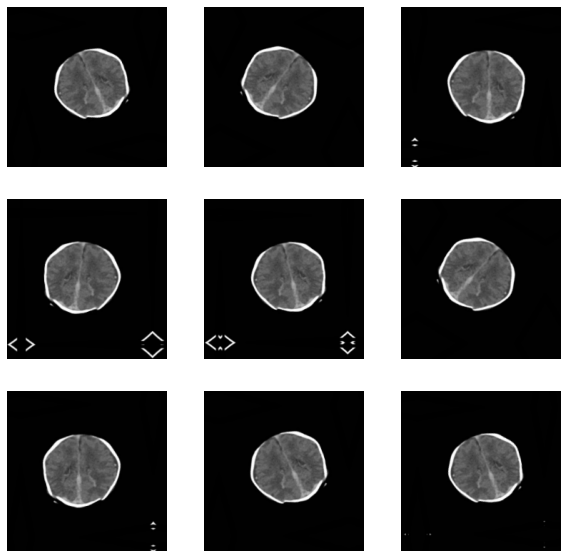

In [7]:
plt.figure(figsize=(10, 10))
for images, _ in train_df.take(3):
    for i in range(9):
        augmented_images = data_augmentation(images)
        ax = plt.subplot(3, 3, i + 1)
        plt.imshow(augmented_images[0].numpy().astype("uint8"))
        plt.axis("off")

In [8]:
train_df = train_df.prefetch(buffer_size=32)
val_df = val_df.prefetch(buffer_size=32)

In [9]:
# Hyperparameters
IMG_IND=224
IMG_SHAPE = (IMG_IND,IMG_IND,3)
LOSS = BinaryCrossentropy()
OPTIMIZER =Adam(learning_rate=0.001, beta_1=0.9, beta_2=0.999)
#OPTIMIZER =RMSprop(learning_rate=0.001)
METRICS = [
      keras.metrics.TruePositives(name='tp'), #True Positive
      keras.metrics.FalsePositives(name='fp'), #False Positive
      keras.metrics.TrueNegatives(name='tn'), 
      keras.metrics.FalseNegatives(name='fn'), 
      keras.metrics.BinaryAccuracy(name='BinaryAccuracy'),
      keras.metrics.Precision(name='precision'),
      keras.metrics.Recall(name='recall'),
      keras.metrics.AUC(name='auc'),
]

IMG_SIZE = (224, 224)
SEED = 2
BATCH_SIZE = 32

In [10]:
def get_callbacks(model_name):
    callbacks =[]
    tensor_board = tf.keras.callbacks.TensorBoard(log_dir='./logs', histogram_freq=0)
    callbacks.append(tensor_board)
    checkpoint = tf.keras.callbacks.ModelCheckpoint(filepath=f'model.{model_name}.h5', verbose=1, monitor='val_loss',mode='min',save_best_only=True)
    callbacks.append(checkpoint)
    anne = ReduceLROnPlateau(monitor='val_loss', factor=0.1, patience=5, verbose=2, min_lr=0.0001,min_delta=0.00001,mode='auto') 
    callbacks.append(anne)
    return callbacks

In [11]:
base_model = tf.keras.applications.ResNet50(input_shape=IMG_SHAPE,include_top=False,weights='imagenet')
base_model.trainable = True
x = base_model.output
x = GlobalAveragePooling2D()(x)
x = keras.layers.Dropout(0.6)(x)  # Regularize with dropout
output = keras.layers.Dense(1)(x)

#adding regularization 



for layer in base_model.layers:
    layer.kernel_regularizer = tf.keras.regularizers.l1_l2(0.0000001)
#    for attr in ['kernel_regularizer']:
#        if hasattr(layer, attr):
#          setattr(layer, attr, regularizer)


    
predictions = Dense(1, activation='sigmoid',name='Final')(x)
model = Model(inputs=base_model.input, outputs=predictions)
model.compile(loss ='binary_crossentropy',optimizer=OPTIMIZER,metrics=METRICS)

94773248/94765736 [==============================] - 4s 0us/step


In [12]:
callbacks = get_callbacks('dense121')
history_dense121 = model.fit( train_df,epochs=20,
                    validation_data= val_df,
                    callbacks=[callbacks])

Epoch 1/20
57/57 [==============================] - 27s 254ms/step - loss: 0.8333 - tp: 467.7069 - fp: 194.0000 - tn: 151.9655 - fn: 128.9828 - BinaryAccuracy: 0.6290 - precision: 0.6903 - recall: 0.7526 - auc: 0.6324 - val_loss: 1919.2748 - val_tp: 277.0000 - val_fp: 173.0000 - val_tn: 0.0000e+00 - val_fn: 0.0000e+00 - val_BinaryAccuracy: 0.6156 - val_precision: 0.6156 - val_recall: 1.0000 - val_auc: 0.5000

Epoch 00001: val_loss improved from inf to 1919.27478, saving model to model.dense121.h5
Epoch 2/20
57/57 [==============================] - 12s 198ms/step - loss: 0.3548 - tp: 546.3793 - fp: 85.7069 - tn: 258.1034 - fn: 52.4655 - BinaryAccuracy: 0.8401 - precision: 0.8495 - recall: 0.9131 - auc: 0.9172 - val_loss: 132.4630 - val_tp: 277.0000 - val_fp: 173.0000 - val_tn: 0.0000e+00 - val_fn: 0.0000e+00 - val_BinaryAccuracy: 0.6156 - val_precision: 0.6156 - val_recall: 1.0000 - val_auc: 0.5000

Epoch 00002: val_loss improved from 1919.27478 to 132.46298, saving model to model.dense

In [13]:
results_dense121 = model.evaluate(test_df, steps=len(test_df), verbose=1)

8/8 [==============================] - 2s 87ms/step - loss: 0.2347 - tp: 119.0000 - fp: 5.0000 - tn: 120.0000 - fn: 6.0000 - BinaryAccuracy: 0.9560 - precision: 0.9597 - recall: 0.9520 - auc: 0.9743


In [14]:
print('DesnseNet121- ADAM:')
print('---------------')
print("Binary Accuracy: ",(results_dense121[5]))
print("Precision: ",(results_dense121[6]))
print("Recall: ",(results_dense121[7]))
print("AUC: ",(results_dense121[8]))
print("F1 Score: ",(2*((results_dense121[6]*results_dense121[7])/((results_dense121[6]+results_dense121[7])))))

DesnseNet121- ADAM:
---------------
Binary Accuracy:  0.9559999704360962
Precision:  0.9596773982048035
Recall:  0.9520000219345093
AUC:  0.9743359684944153
F1 Score:  0.9558232937379639


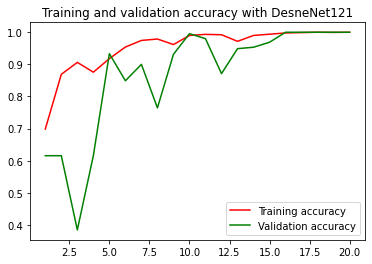

<Figure size 432x288 with 0 Axes>

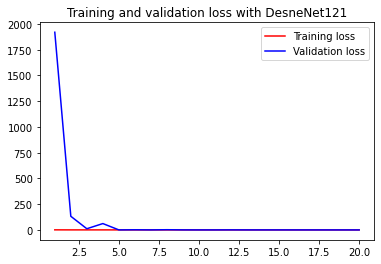

In [15]:
model.save('brain_stroke_detection_DesneNet121.h5')

import matplotlib.pyplot as plt

acc = history_dense121.history['BinaryAccuracy']
val_acc = history_dense121.history['val_BinaryAccuracy']
loss = history_dense121.history['loss']
val_loss = history_dense121.history['val_loss']

epochs = range(1, len(acc) + 1)

fig = plt.figure(figsize=(6,4))
plt.plot(epochs, acc, 'r', label='Training accuracy')
plt.plot(epochs, val_acc, 'g', label='Validation accuracy')
plt.title('Training and validation accuracy with DesneNet121')
plt.legend()

plt.figure()

fig = plt.figure(figsize=(6,4))
plt.plot(epochs, loss, 'r', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss with DesneNet121')
plt.legend()

<Figure size 432x288 with 0 Axes>

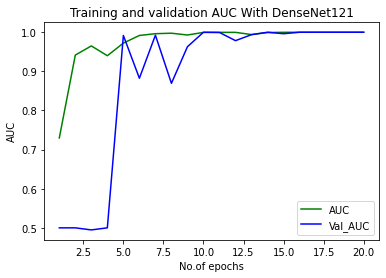

<Figure size 432x288 with 0 Axes>

In [16]:
AUC = history_dense121.history['auc']
val_AUC = history_dense121.history['val_auc']

epochs = range(1, len(acc) + 1)

fig = plt.figure(figsize=(6,4))
plt.plot(epochs, AUC, 'g', label='AUC')
plt.plot(epochs, val_AUC, 'b', label='Val_AUC')
plt.xlabel('No.of epochs')
plt.ylabel('AUC')
plt.title('Training and validation AUC With DenseNet121')
plt.legend()
plt.figure()

<a href="./brain_stroke_detection_DesneNet121.h5">Download model densenet121 </a>

In [17]:
import numpy as np


def plot_confusion_matrix(cm,
                          target_names_y,
                          target_names_x,
                          title='Confusion matrix',
                          cmap=None,
                          normalize=True):
    """
    given a sklearn confusion matrix (cm), make a nice plot

    Arguments
    ---------
    cm:           confusion matrix from sklearn.metrics.confusion_matrix

    target_names: given classification classes such as [0, 1, 2]
                  the class names, for example: ['high', 'medium', 'low']

    title:        the text to display at the top of the matrix

    cmap:         the gradient of the values displayed from matplotlib.pyplot.cm
                  see http://matplotlib.org/examples/color/colormaps_reference.html
                  plt.get_cmap('jet') or plt.cm.Blues

    normalize:    If False, plot the raw numbers
                  If True, plot the proportions

    Usage
    -----
    plot_confusion_matrix(cm           = cm,                  # confusion matrix created by
                                                              # sklearn.metrics.confusion_matrix
                          normalize    = True,                # show proportions
                          target_names = y_labels_vals,       # list of names of the classes
                          title        = best_estimator_name) # title of graph

    Citiation
    ---------
    http://scikit-learn.org/stable/auto_examples/model_selection/plot_confusion_matrix.html

    """
    import matplotlib.pyplot as plt
    import numpy as np
    import itertools

    accuracy = np.trace(cm) / float(np.sum(cm))
    misclass = 1 - accuracy

    if cmap is None:
        cmap = plt.get_cmap('Blues')

    plt.figure(figsize=(8, 6))
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()

    if target_names_x is not None:
        tick_marks = np.arange(len(target_names_x))
        plt.xticks(tick_marks, target_names_x, rotation=45)
        plt.yticks(tick_marks, target_names_y)

    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]


    thresh = cm.max() / 1.5 if normalize else cm.max() / 2
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        if normalize:
            plt.text(j, i, "{:0.4f}".format(cm[i, j]),
                     horizontalalignment="center",
                     color="white" if cm[i, j] > thresh else "black")
        else:
            plt.text(j, i, "{:,}".format(cm[i, j]),
                     horizontalalignment="center",
                     color="white" if cm[i, j] > thresh else "black")


    plt.tight_layout()
   # plt.ylabel('True label')
   
    plt.show()

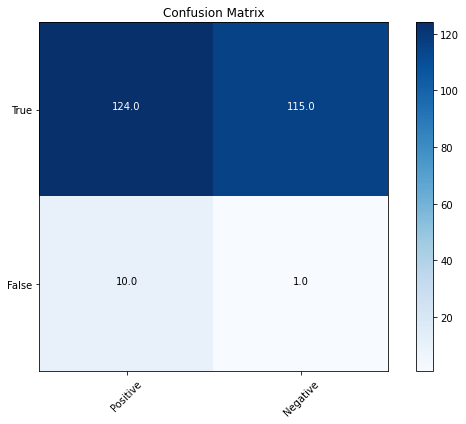

In [18]:
plot_confusion_matrix(cm           = np.array([[ 124.0000,  115.0000],
                                              [  10.0000,  1.0000],
                                              ]), 
                      normalize    = False,
                      target_names_x = ['Positive', 'Negative'],
                      target_names_y = ['True', 'False'],
                      title        = "Confusion Matrix")